In [ ]:
# https://docs.gpytorch.ai/en/v1.6.0/examples/04_Variational_and_Approximate_GPs/Approximate_GP_Objective_Functions.html

In [1]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

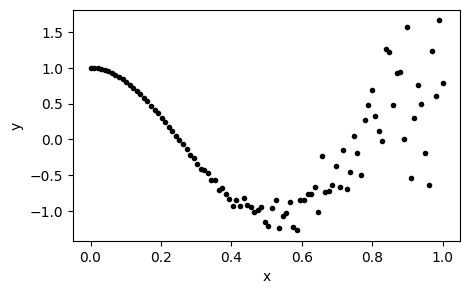

In [2]:
# Define some training data
train_x = torch.linspace(0, 1, 100)
train_y = torch.cos(train_x * 2 * math.pi) + torch.randn(100).mul(train_x.pow(3) * 1.)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.scatter(train_x, train_y, c='k', marker='.', label="Data")
ax.set(xlabel="x", ylabel="y")

In [3]:
class ApproximateGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(-1))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Our testing script takes in a GPyTorch MLL (objective function) class
# and then trains/tests an approximate GP with it on the supplied dataset

def train_and_test_approximate_gp(objective_function_cls):
    model = ApproximateGPModel(torch.linspace(start=0, end=1, steps=100))
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    objective_function = objective_function_cls(likelihood, model, num_data=train_y.numel())
    optimizer = torch.optim.Adam(list(model.parameters()) + list(likelihood.parameters()), lr=0.1)

    # Train
    model.train()
    likelihood.train()
    for _ in range(training_iterations):
        output = model(train_x)
        loss = -objective_function(output, train_y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Test
    model.eval()
    likelihood.eval()
    with torch.no_grad():
        f_dist = model(train_x)
        mean = f_dist.mean
        f_lower, f_upper = f_dist.confidence_region()
        y_dist = likelihood(f_dist)
        y_lower, y_upper = y_dist.confidence_region()

    # Plot model
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    line, = ax.plot(train_x, mean, "blue")
    ax.fill_between(train_x, f_lower, f_upper, color=line.get_color(), alpha=0.3, label="q(f)")
    ax.fill_between(train_x, y_lower, y_upper, color=line.get_color(), alpha=0.1, label="p(y)")
    ax.scatter(train_x, train_y, c='k', marker='.', label="Data")
    ax.legend(loc="best")
    ax.set(xlabel="x", ylabel="y")

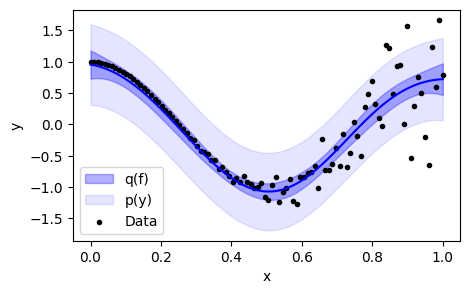

In [7]:
train_and_test_approximate_gp(gpytorch.mlls.VariationalELBO)

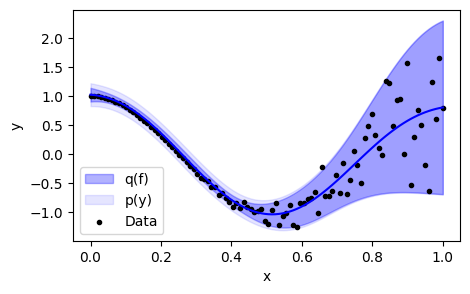

In [8]:
train_and_test_approximate_gp(gpytorch.mlls.PredictiveLogLikelihood)

In [21]:
# example using botorch
from gpytorch.mlls import PredictiveLogLikelihood
from botorch.models import SingleTaskVariationalGP
from botorch import fit_gpytorch_mll
from botorch.models.transforms import Normalize, Standardize

dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def outcome_objective(x):
    return torch.cos(x * 2 * math.pi) + torch.randn(x.shape, dtype=dtype).mul(x.pow(3) * 1.)

train_X = torch.rand(200,1, dtype=dtype)
train_Y = outcome_objective(train_X)

model_svi = SingleTaskVariationalGP(train_X, train_Y,
                                    outcome_transform=Standardize(m=train_Y.shape[-1]),
                                    input_transform=Normalize(d=train_X.shape[-1]),)
mll_svi = PredictiveLogLikelihood(model_svi.likelihood, model_svi.model, num_data=train_X.shape[-2])
fitting_svi = fit_gpytorch_mll(mll_svi)

c:\Users\alexb\Documents\GitHub\data-science-learning\gaussian-processes\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: UserInputWarning: Using an outcome transform with `SingleTaskVariationalGP`. If this model is trained in minibatches, a outcome transform with learnable parameters would update its parameters for each minibatch, which is undesirable. If you do intend to train in minibatches, we recommend you not use a outcome transform and instead pre-transform your whole data set before fitting the model.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\alexb\Documents\GitHub\data-science-learning\gaussian-processes\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: UserInputWarning: Using an input transform with `SingleTaskVariationalGP`. If this model is trained in minibatches, a input transform with learnable parameters would update its parameters for each minibatch, which is undesirable. If you do intend to train in minibatches, we recommen

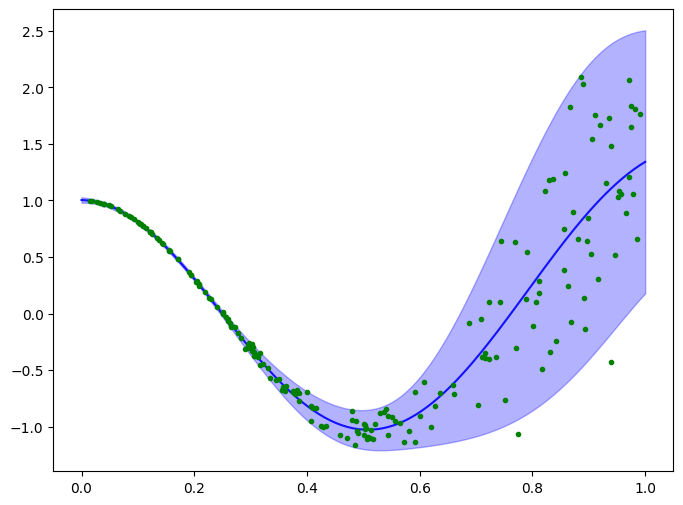

In [22]:

fig, ax = plt.subplots(1,1, figsize=(8,6))
x_plot = torch.linspace(0,1,200, dtype=dtype, device=device).unsqueeze(-1)
# get posterior
model_posterior_svi = model_svi.posterior(x_plot, observation_noise=True)
# get and plot mean
mean_svi = model_posterior_svi.mean.detach().squeeze().numpy()
ax.plot(x_plot.numpy(),mean_svi,'b-', alpha=0.9)
# get confidence bounds and plot
lower_svi, upper_svi  = model_posterior_svi.mvn.confidence_region()
ax.fill_between(x_plot.squeeze().numpy(), lower_svi.detach().numpy(), upper_svi.detach().numpy(), color='b', alpha=0.3)
# plot training data points
ax.plot(train_X.numpy(), train_Y.numpy(), 'g.')
None

In [23]:
from gpytorch.mlls import VariationalELBO

model_elbo = SingleTaskVariationalGP(train_X, train_Y,
                                    outcome_transform=Standardize(m=train_Y.shape[-1]),
                                    input_transform=Normalize(d=train_X.shape[-1]),)
mll_elbo = VariationalELBO(model_elbo.likelihood, model_elbo.model, num_data=train_X.shape[-2])
fitting_elbo = fit_gpytorch_mll(mll_elbo)

c:\Users\alexb\Documents\GitHub\data-science-learning\gaussian-processes\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: UserInputWarning: Using an outcome transform with `SingleTaskVariationalGP`. If this model is trained in minibatches, a outcome transform with learnable parameters would update its parameters for each minibatch, which is undesirable. If you do intend to train in minibatches, we recommend you not use a outcome transform and instead pre-transform your whole data set before fitting the model.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\alexb\Documents\GitHub\data-science-learning\gaussian-processes\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3577: UserInputWarning: Using an input transform with `SingleTaskVariationalGP`. If this model is trained in minibatches, a input transform with learnable parameters would update its parameters for each minibatch, which is undesirable. If you do intend to train in minibatches, we recommen

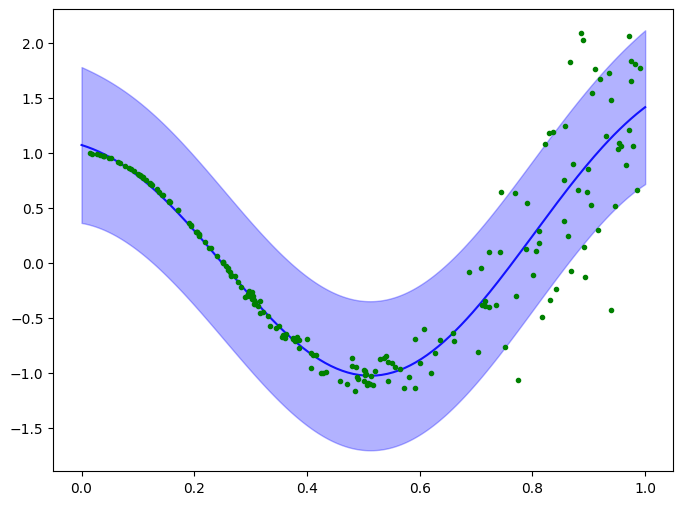

In [24]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
x_plot = torch.linspace(0,1,200, dtype=dtype, device=device).unsqueeze(-1)
# get posterior
model_posterior_elbo = model_elbo.posterior(x_plot, observation_noise=True)
# get and plot mean
mean_elbo = model_posterior_elbo.mean.detach().squeeze().numpy()
ax.plot(x_plot.numpy(),mean_elbo,'b-', alpha=0.9)
# get confidence bounds and plot
lower_elbo, upper_elbo  = model_posterior_elbo.mvn.confidence_region()
ax.fill_between(x_plot.squeeze().numpy(), lower_elbo.detach().numpy(), upper_elbo.detach().numpy(), color='b', alpha=0.3)
# plot training data points
ax.plot(train_X.numpy(), train_Y.numpy(), 'g.')
None